# Imputation stability

We explore various expectile imputation strategies and their stability through repeated imputation.

In [11]:
import importlib

import numpy as np
import matplotlib.pyplot as plt

import tqdm.notebook as tqdm

from util.expectiles import expectile, tauspace
from util.gmm import GMM

import imputers
imputers = importlib.reload(imputers) # reload

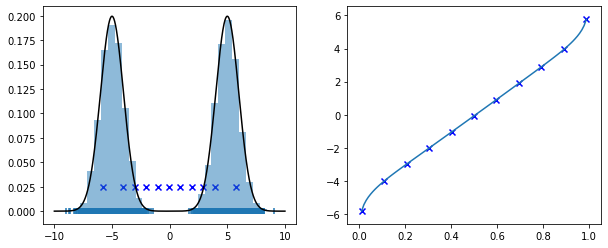

-0.06635824172701943


In [2]:
R = GMM(coeffs=[0.5, 0.5], params=[[-5, 1], [5, 1]])
N = 10000
SAMPLE = R.rvs(N)
GMM_X = np.linspace(-10, 10, 1000)
GMM_Y = R.pdf(GMM_X)
T = np.linspace(0.01, 0.99, 101)
E = expectile(SAMPLE, T)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.hist(SAMPLE, density=True, alpha=0.5, bins=30)
ax1.scatter(SAMPLE, np.zeros_like(SAMPLE), marker="|")
ax1.plot(GMM_X, GMM_Y, color="black")
ax1.scatter(E[::10], 0.025*np.ones(11), marker="x", color="blue")
ax2.plot(T, E)
ax2.scatter(T[::10], E[::10], marker="x", color="blue")
plt.show()
print(E[len(E)//2])

## Stability experiments

In [14]:
def shift_experiment(taus, imputer, sample=SAMPLE, n_iterations=100, n_samples=None,
                     cm=plt.cm.gist_rainbow, cm2=plt.cm.summer, bins=None, **kwargs):
    if n_samples is None: n_samples = len(sample)
    print("imputation shift experiment with", imputer)
    print("n samples:    ", n_samples)
    print("n iterations: ", n_iterations)
    # record more expectiles than those provided
    full_taus = tauspace(999)
    expectiles = np.ndarray((n_iterations+1, 999))
    samples = np.ndarray((n_iterations, n_samples))
    sample0 = sample
    fits = []
    # perform experiment:
    expectiles[0] = expectile(sample, full_taus)
    for i in tqdm.trange(1, n_iterations+1):
        imputer.fit(expectile(sample, taus), taus, **kwargs)
        fits.append((imputer.τ, imputer.ε))
        sample = imputer.sample(n_samples)
        try:
            expectiles[i] = expectile(sample, full_taus)
        except IndexError:
            print(sample)
        samples[i-1] = sample
    imputer.fit(expectile(sample, taus), taus, **kwargs)
    fits.append((imputer.τ, imputer.ε))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.set_xlabel("asymmetry (τ)")
    ax1.set_ylabel("expectile (ε)")
    ax2.set_xlabel("sample point")
    ax2.set_ylabel("sample density")
    # visualise:
    if bins is None: bins=np.linspace(min(sample0.min(), samples.min()),
            max(sample0.max(), samples.max()), 100)
    for i in range(0, n_iterations+1, max(1, n_iterations//5)):
        ax1.plot(full_taus, expectiles[i],
                 label=f'after {i} iterations', color=cm(i/n_iterations))
        try:
            ax1.scatter(*fits[i], marker="x", alpha=10/len(fits[i][0]),
                        color=cm(i/n_iterations))
        except:
            pass
        ax2.hist(samples[i-1] if i else sample0,
                 density=True, alpha=0.5, bins=bins,
                 label=f'after {i} iterations', color=cm(i/n_iterations))
    ax1.legend()
    ax2.legend()
    plt.show()
    fig, ax3 = plt.subplots(1, 1, figsize=(14, 5))
    ax3.set_xlabel("number of iterations")
    ax3.set_ylabel("expectile (ε)")
    for i in [998, 899, 799, 699, 599, 499, 399, 299, 199, 99, 0]:
        ax3.plot(expectiles[:, i], marker='x', color=cm(i/999), label=f'τ={full_taus[i]:.4f}')
    plt.legend(loc=(1.01, 0.1))
    plt.show()
    # construct image
    n_bins = n_iterations//2
    bins = np.linspace(min(sample0.min(), samples.min()), max(sample0.max(), samples.max()), n_bins+1)
    data = np.transpose( [np.histogram(sample0, bins=bins)[0][::-1]]
                       + [np.histogram(sample,  bins=bins)[0][::-1] for sample in samples])
    data = data / data.max(axis=0, keepdims=True)
    # plot it
    fig, ax = plt.subplots(1, 1, figsize=(14, 7))
    ax.set_ylabel("x")
    ax.set_xlabel("iterations")
    ax.imshow(data, cmap=cm2)
    ax.set_yticks(np.arange(n_bins, -1, -max(1, n_bins//20)) - 0.5)
    ax.set_yticklabels(bins[::max(1, n_bins//20)].round(1))
    plt.show()

### Deepmind's Naive imputer

imputation shift experiment with NaiveImputer()
n samples:     10000
n iterations:  20


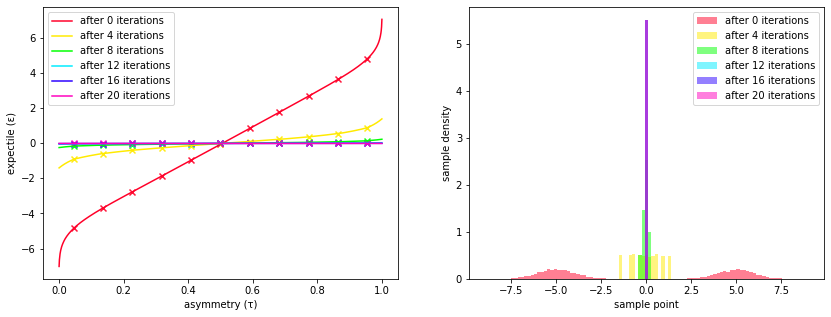

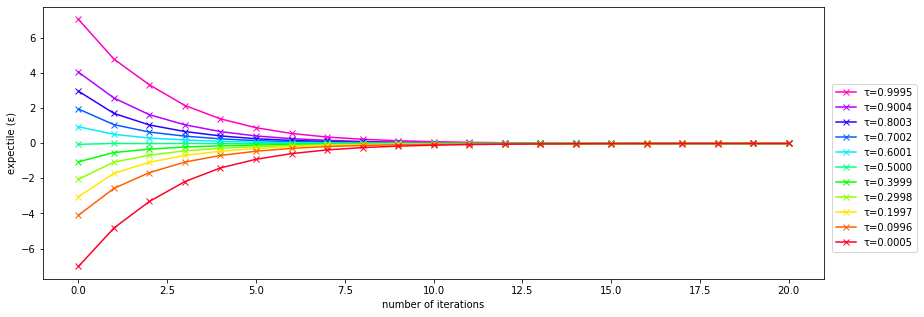

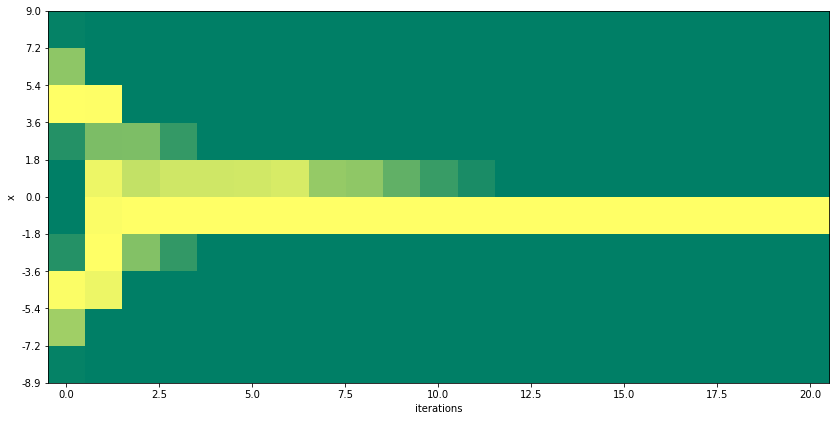

imputation shift experiment with NaiveImputer()
n samples:     10000
n iterations:  20


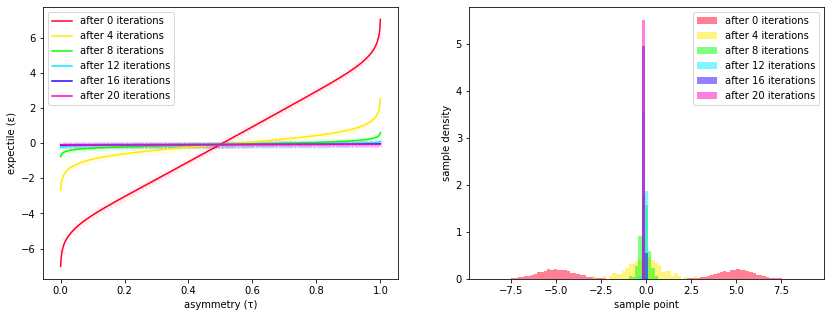

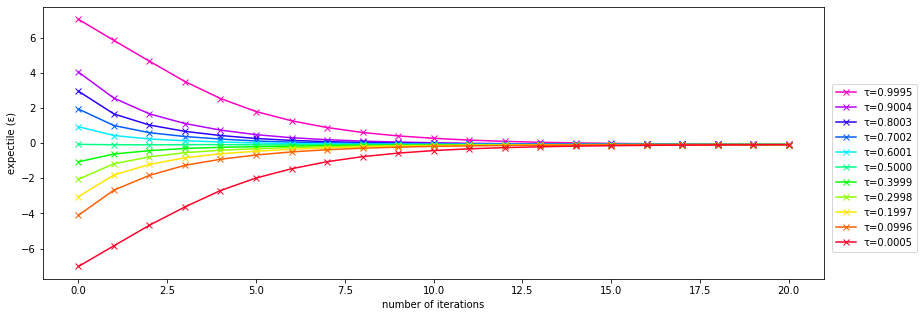

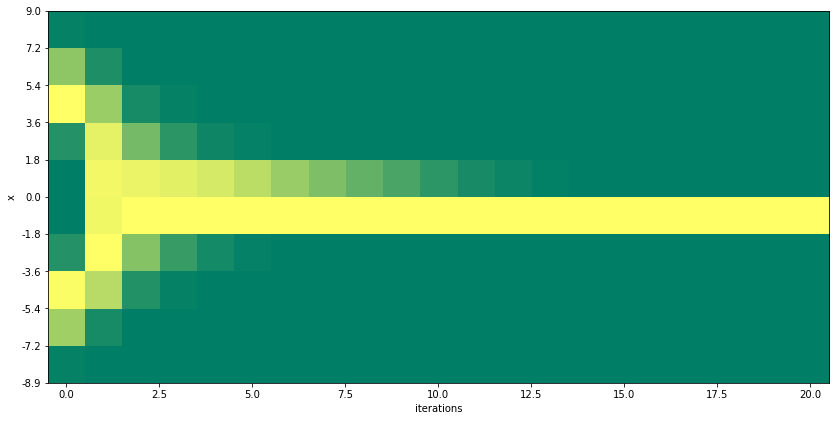

imputation shift experiment with NaiveImputer()
n samples:     10000
n iterations:  20


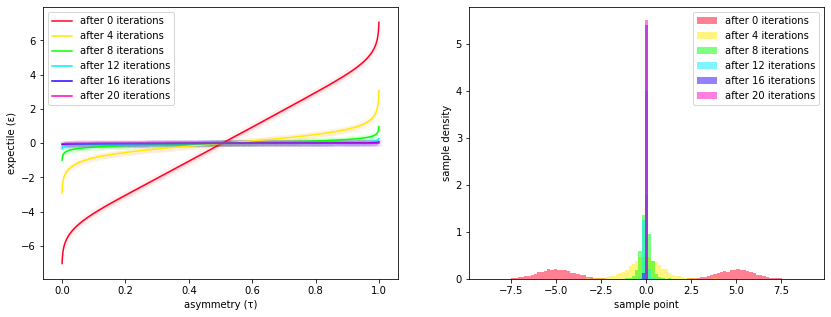

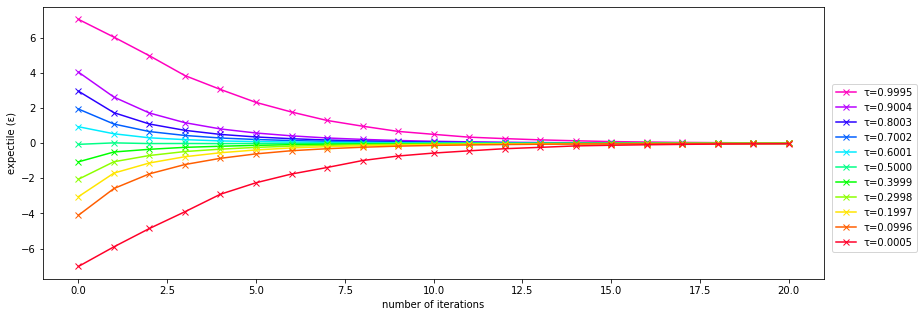

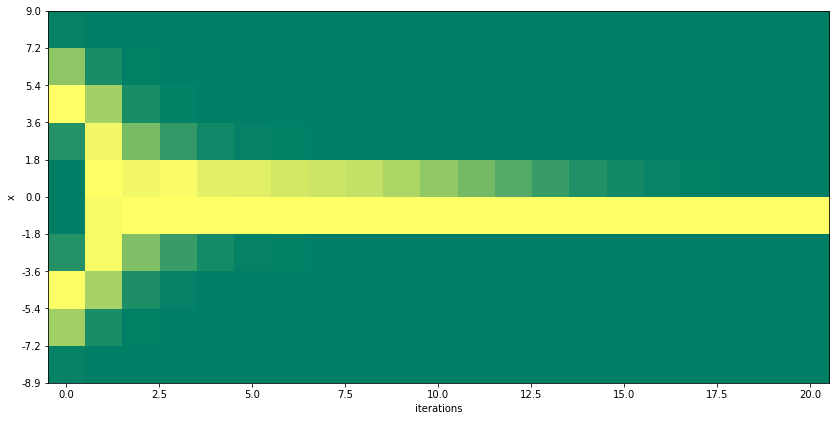

In [15]:
shift_experiment(tauspace(11),   imputers.NaiveImputer(), n_iterations=20)
shift_experiment(tauspace(101),  imputers.NaiveImputer(), n_iterations=20)
shift_experiment(tauspace(1001), imputers.NaiveImputer(), n_iterations=20)

### Deepmind's Optimisation-based imputer

imputation shift experiment with OptBasedImputer(self.method='root', self.start='bestof1000')
n samples:     11
n iterations:  20


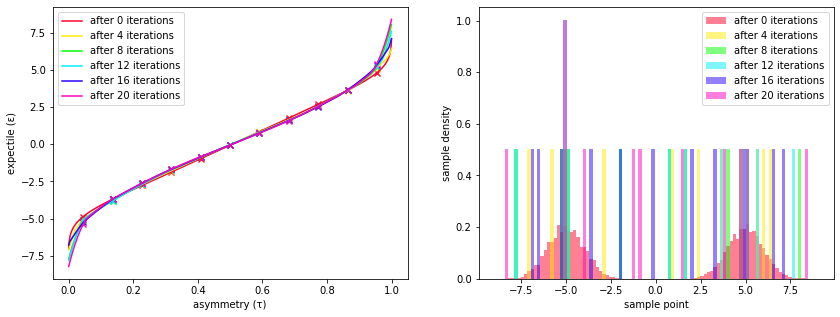

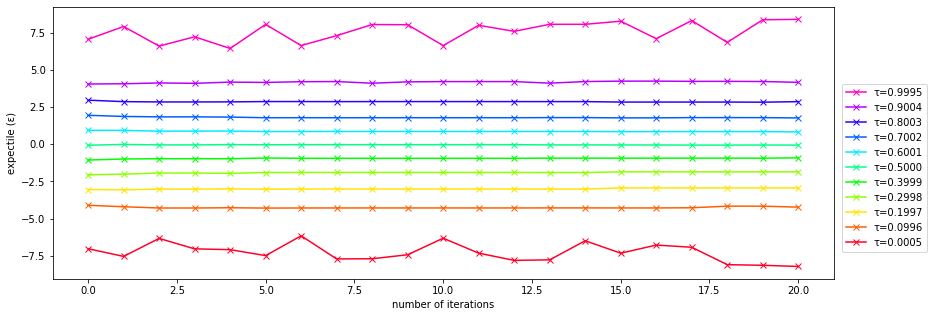

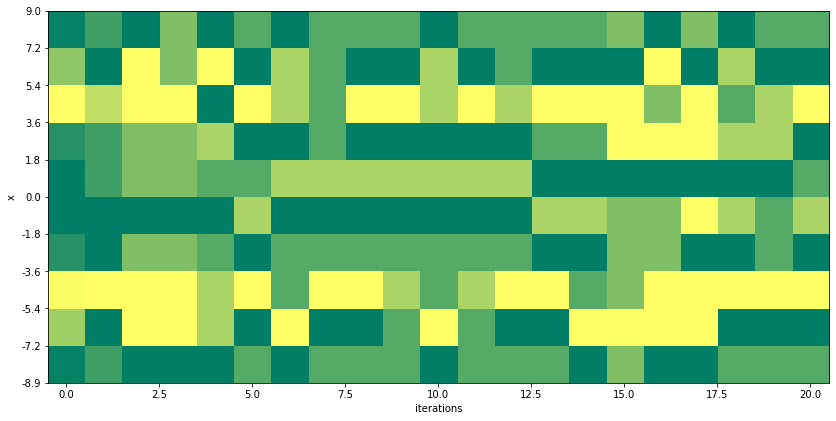

imputation shift experiment with OptBasedImputer(self.method='root', self.start='bestof1000')
n samples:     11
n iterations:  1000


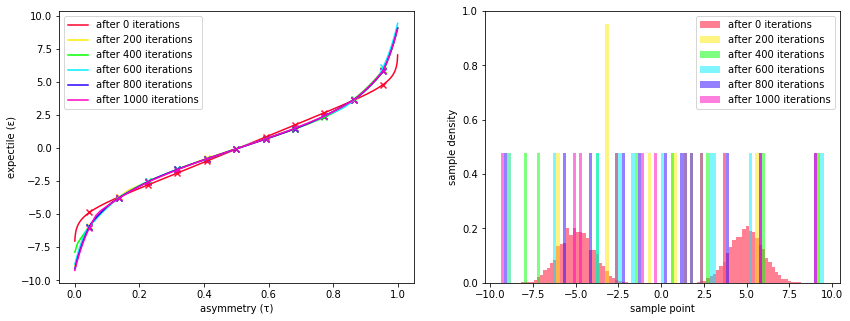

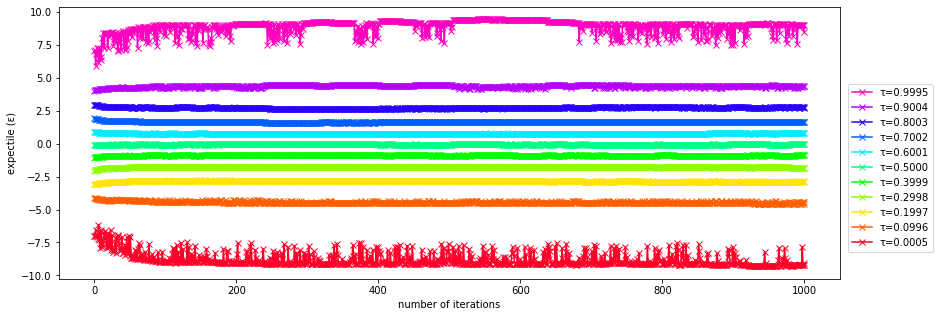

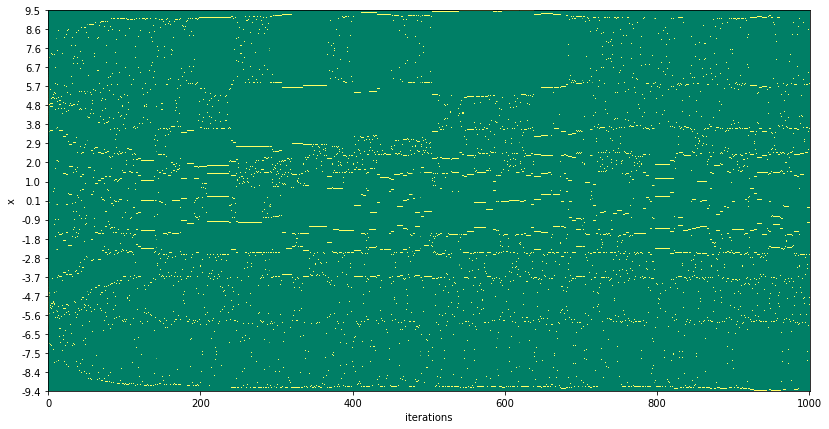

In [16]:
shift_experiment(tauspace(11), imputers.OptBasedImputer(), n_iterations=20,   n_samples=11)
shift_experiment(tauspace(11), imputers.OptBasedImputer(), n_iterations=1000, n_samples=11)

Note to self: very stable! BUT occasionally even this method has a bad imputation and jumps to a wildly different distribution.

imputation shift experiment with OptBasedImputer(self.method='root', self.start='bestof1000')
n samples:     101
n iterations:  20


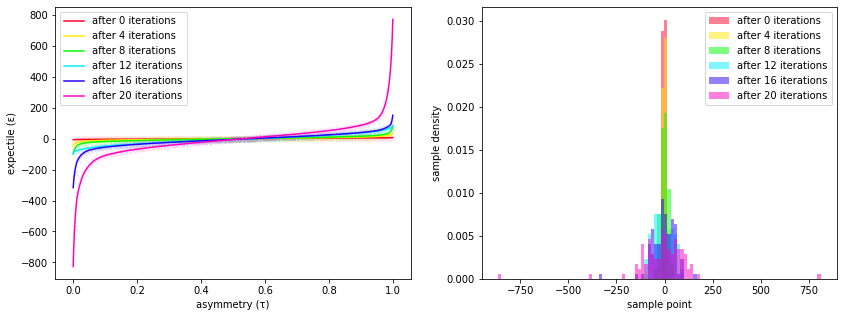

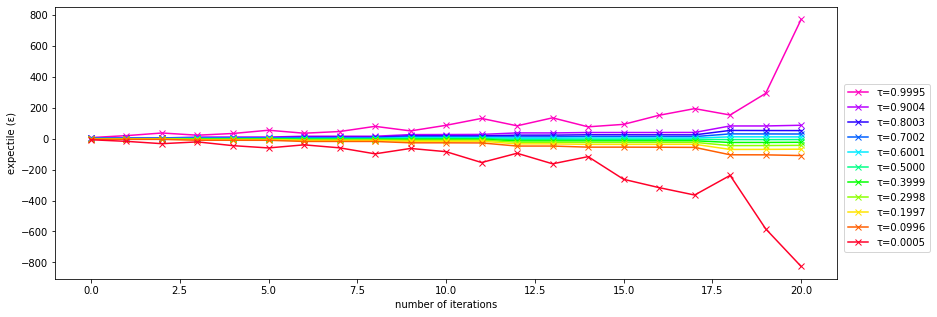

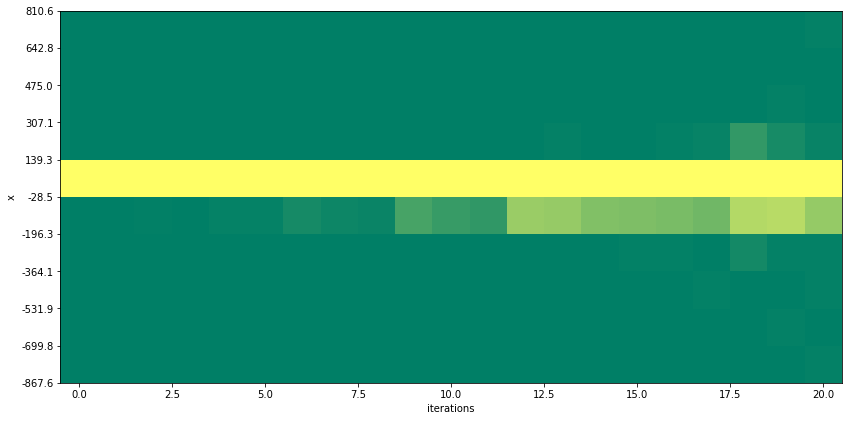

In [32]:
shift_experiment(tauspace(101), imputers.OptBasedImputer(), n_iterations=20, n_samples=101)

When we increase the number of taus, the optimiser doesn't do as reliable a job at recovering the sample. We see either collapse or explosion (... why one or the other, and not both at once?)

### 'Direct' imputer

imputation shift experiment with DirectImputer(self.smooth_invert=False, self.exp_tails=False)
n samples:     10000
n iterations:  20


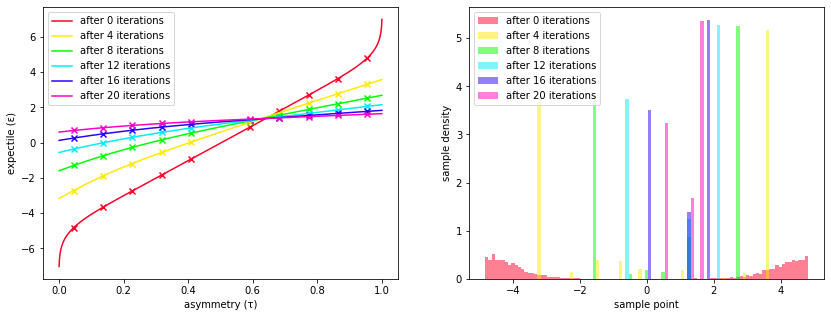

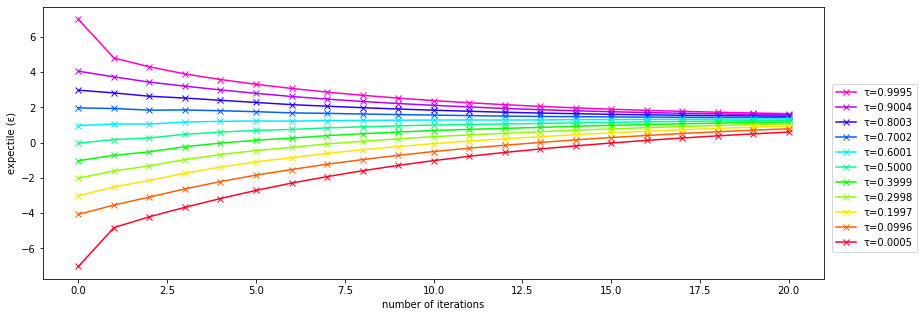

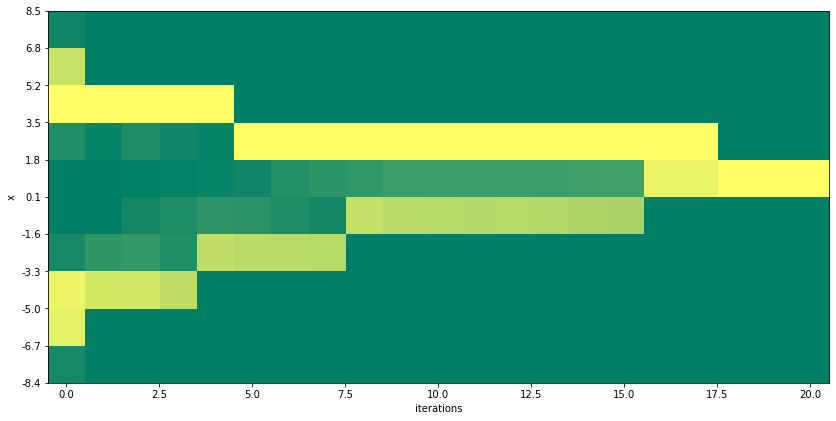

imputation shift experiment with DirectImputer(self.smooth_invert=False, self.exp_tails=False)
n samples:     10000
n iterations:  20


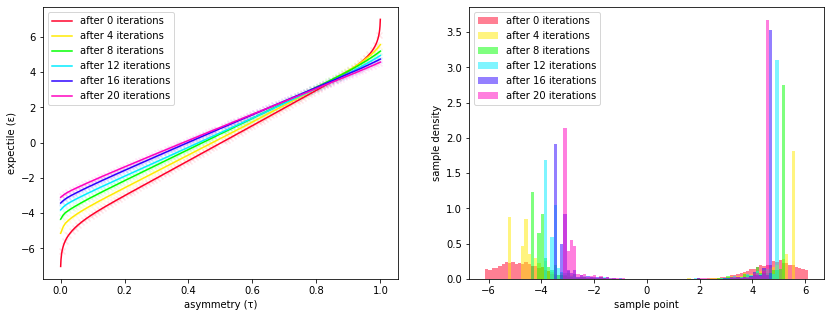

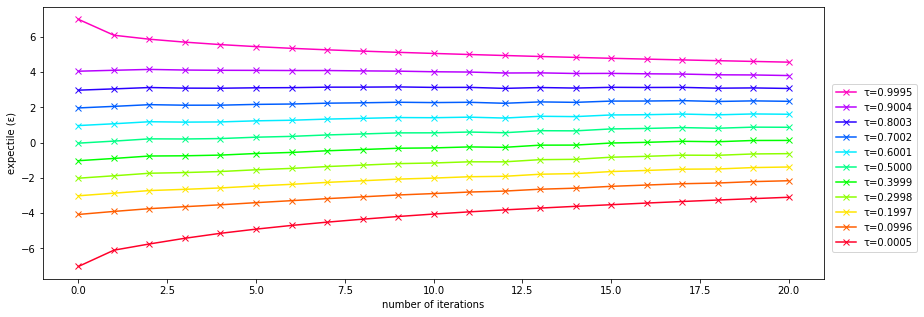

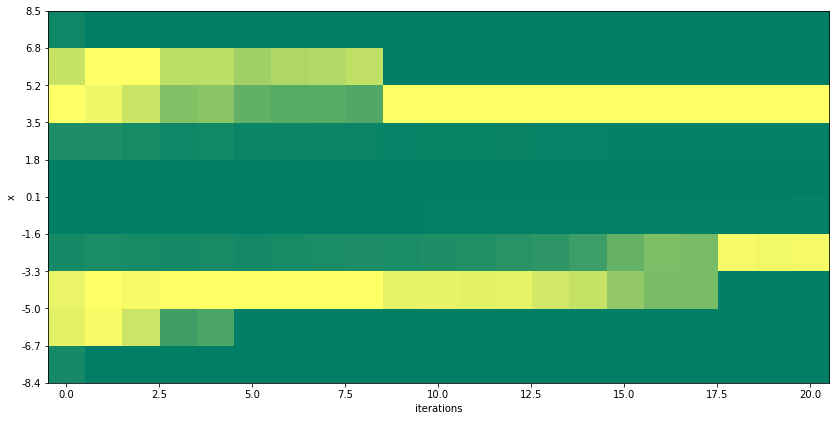

In [36]:
shift_experiment(tauspace(11),  imputers.DirectImputer(), n_iterations=20)
shift_experiment(tauspace(101), imputers.DirectImputer(), n_iterations=20)

imputation shift experiment with DirectImputer(self.smooth_invert=True, self.exp_tails=True)
n samples:     10000
n iterations:  5


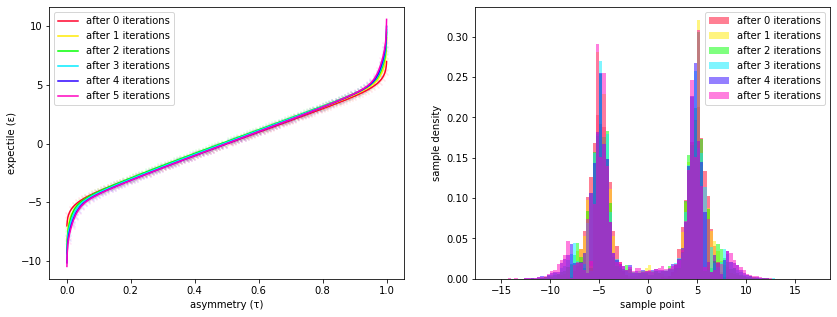

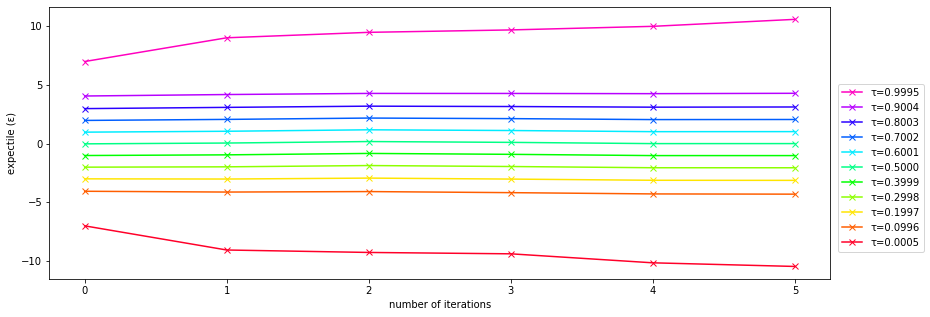

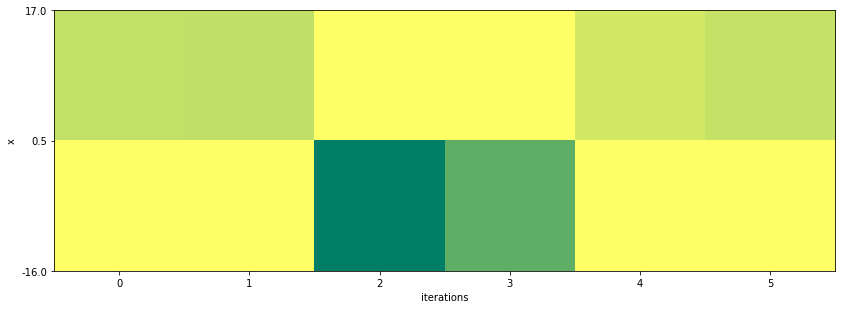

imputation shift experiment with DirectImputer(self.smooth_invert=True, self.exp_tails=True)
n samples:     10000
n iterations:  1000


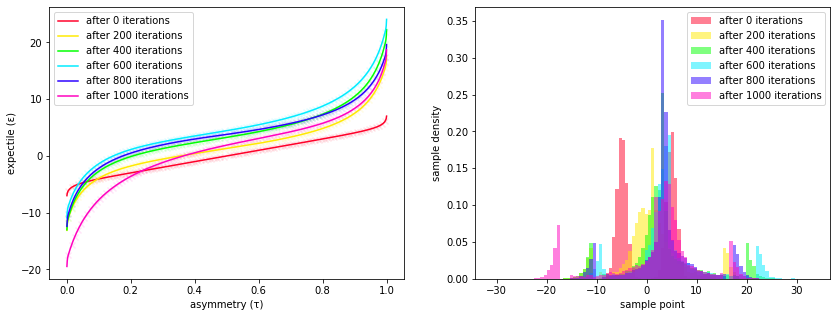

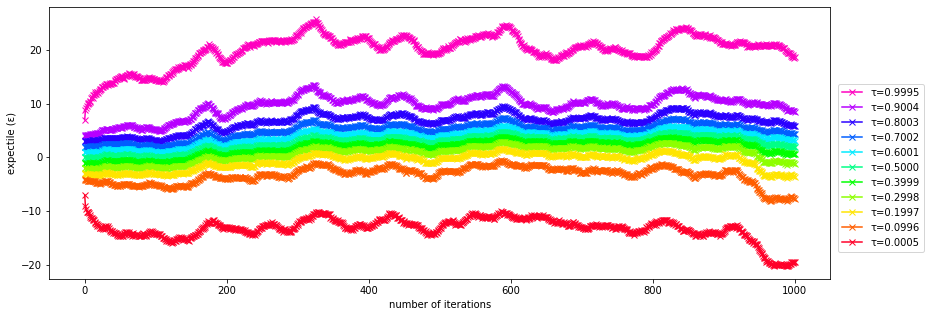

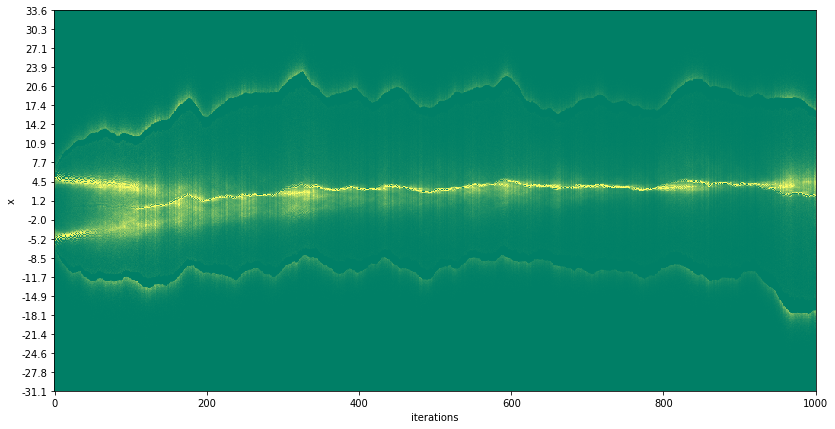

In [74]:
shift_experiment(tauspace(101), imputers.DirectImputer(smooth_invert=True, exp_tails=True), n_iterations=5)
shift_experiment(tauspace(101), imputers.DirectImputer(smooth_invert=True, exp_tails=True), n_iterations=1000)

imputation shift experiment with DirectImputer(self.smooth_invert=True, self.exp_tails=False)
n samples:     10000
n iterations:  20


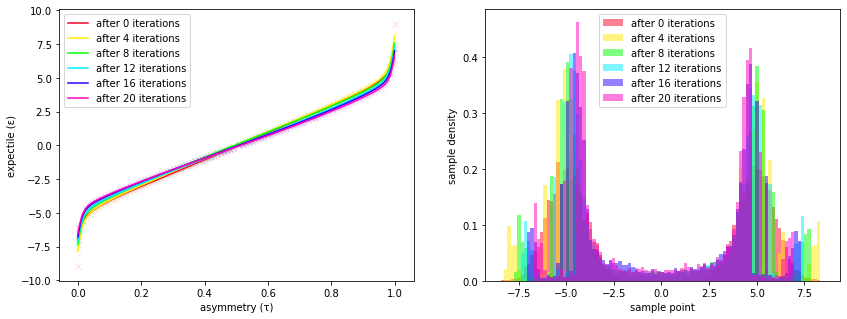

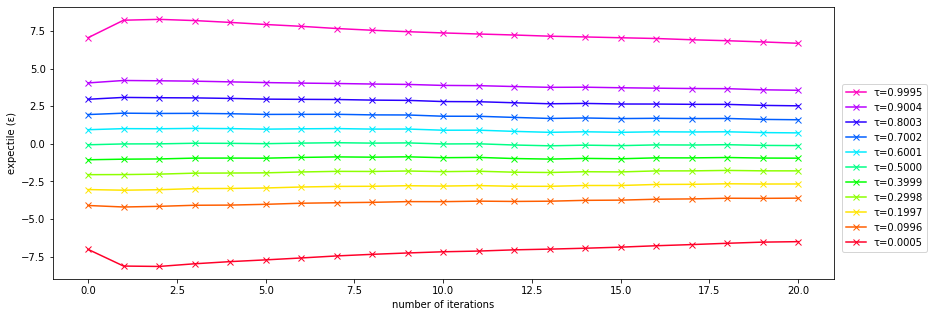

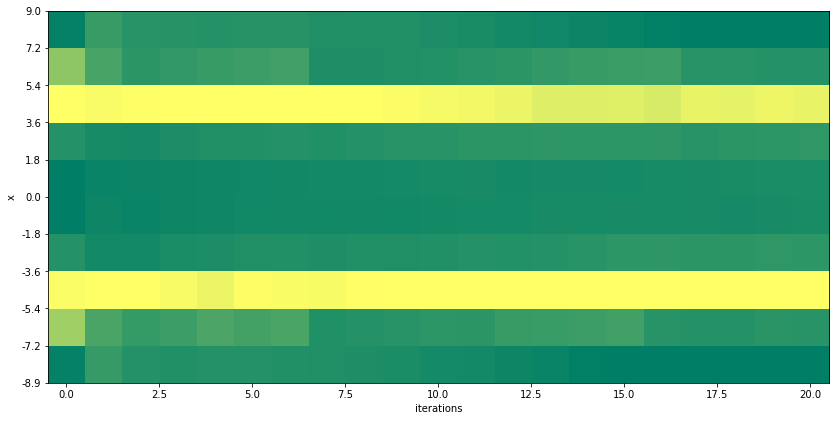

imputation shift experiment with DirectImputer(self.smooth_invert=True, self.exp_tails=False)
n samples:     10000
n iterations:  1000


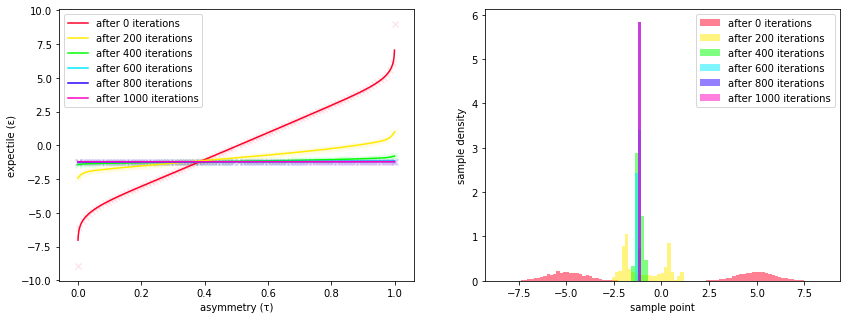

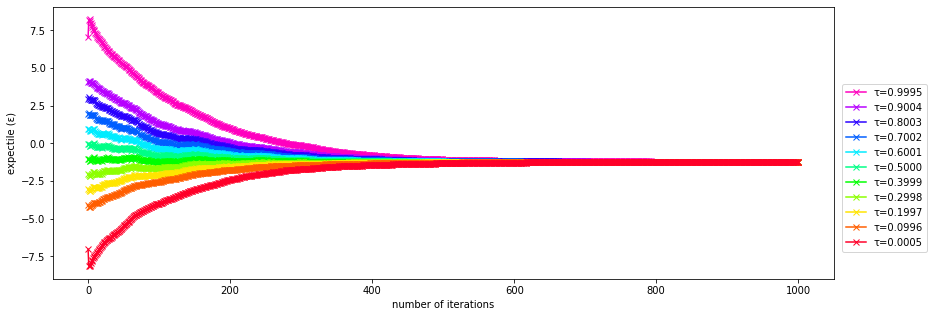

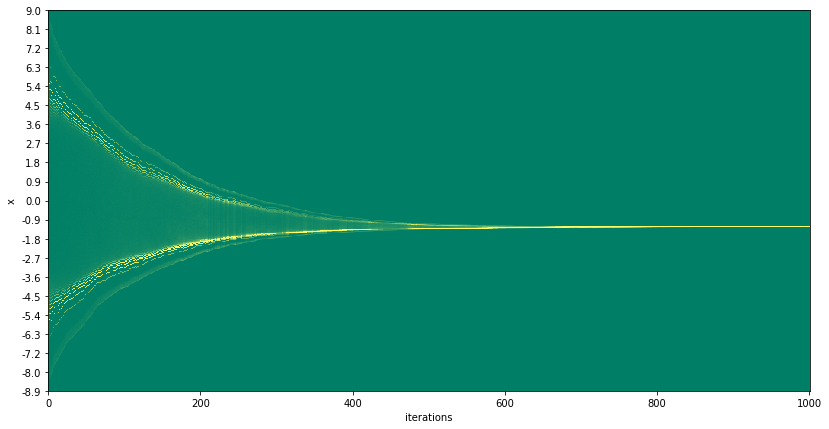

In [9]:
def full_tauspace(k):
    return np.concatenate([[0.], tauspace(k), [1.]])
    
shift_experiment(full_tauspace(101), imputers.DirectImputer(smooth_invert=True, exp_tails=False), n_iterations=20)
shift_experiment(full_tauspace(101), imputers.DirectImputer(smooth_invert=True, exp_tails=False), n_iterations=1000)

### Direct imputer with logit-linear interpolation and extrapolation of CDF

imputation shift experiment with InterpolatingImputer()
n samples:     10000
n iterations:  20


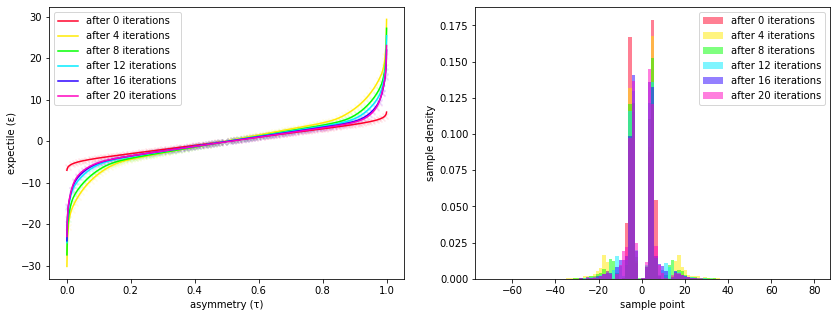

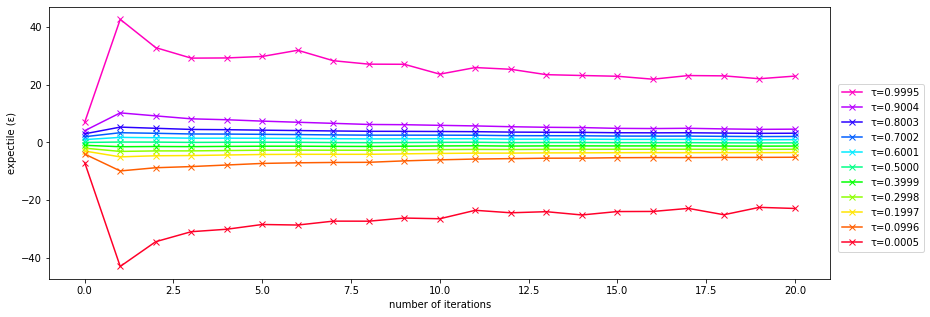

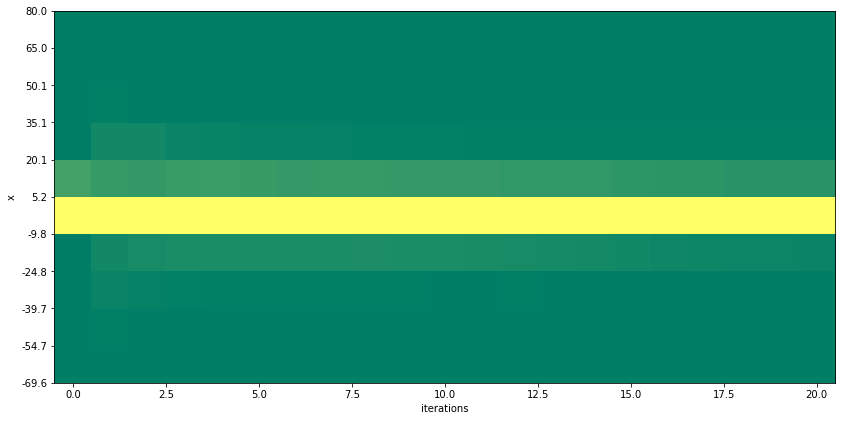

imputation shift experiment with InterpolatingImputer()
n samples:     10000
n iterations:  100


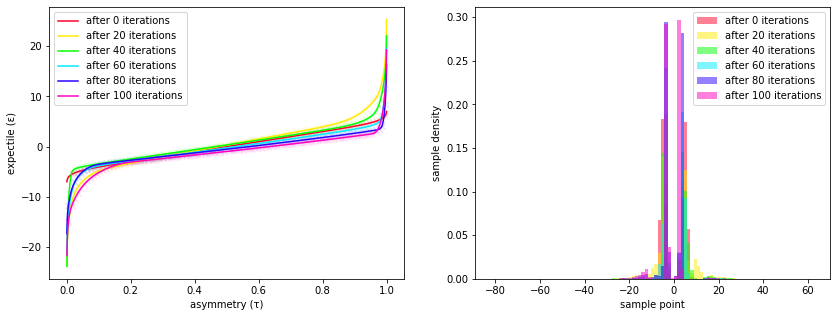

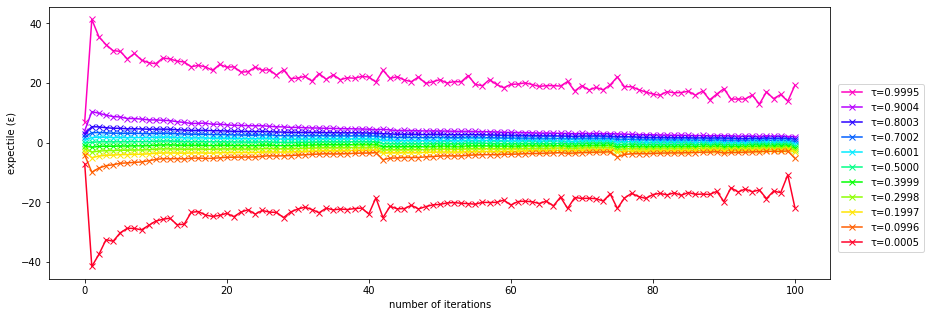

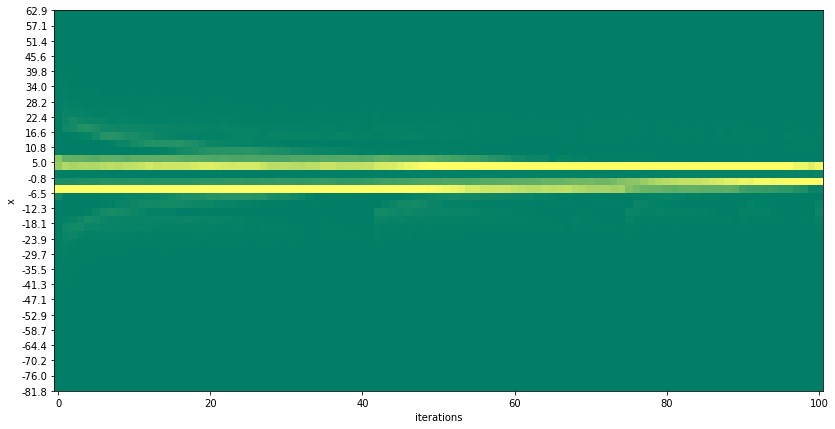

In [38]:
shift_experiment(tauspace(101), imputers.InterpolatingImputer(), n_iterations=20)
shift_experiment(tauspace(101), imputers.InterpolatingImputer(), n_iterations=100)

### Fit a logit polynomial to the expectile function

imputation shift experiment with PolyLogitImputer(self.degree=3)
n samples:     101
n iterations:  20


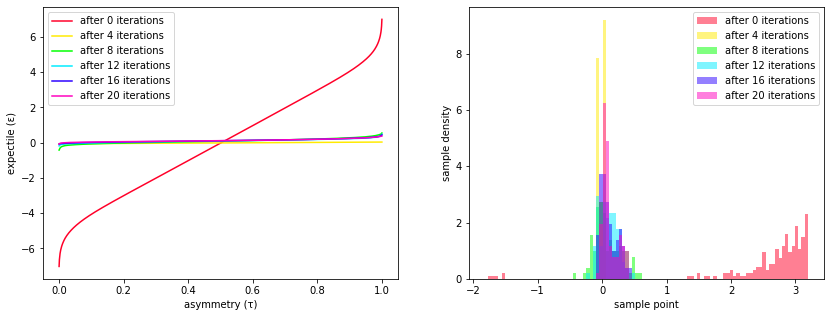

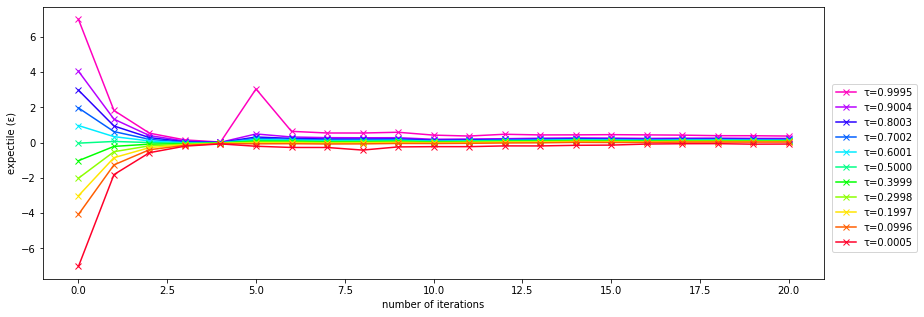

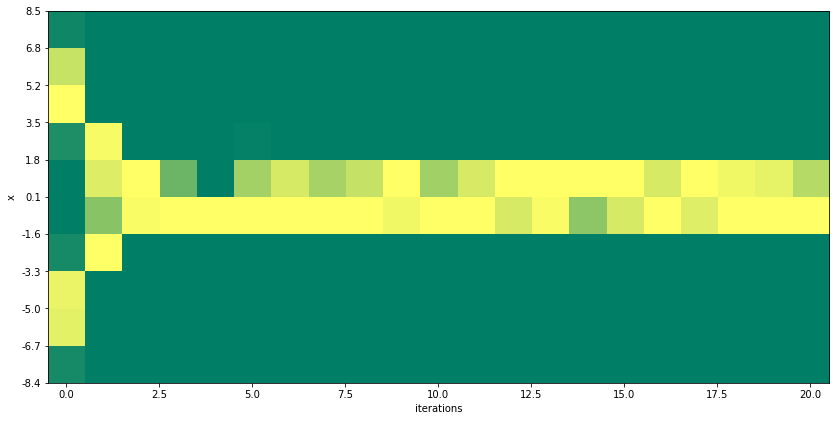

In [39]:
shift_experiment(tauspace(101), imputers.PolyLogitImputer(batch_size=None), n_iterations=20, n_samples=101)

imputation shift experiment with PolyLogitImputer(self.degree=1)
n samples:     1000
n iterations:  20


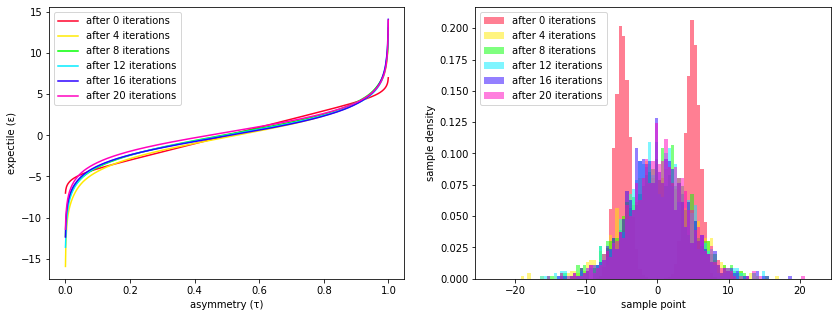

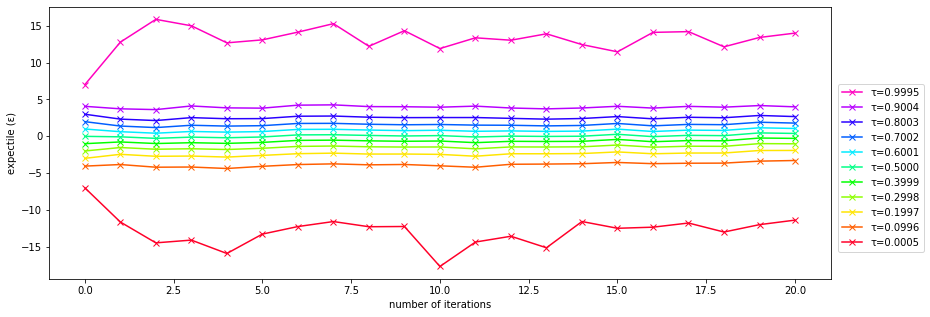

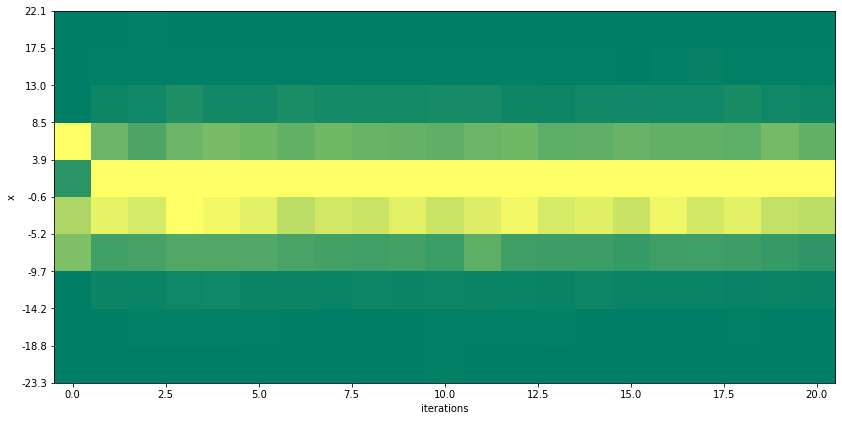

In [44]:
shift_experiment(tauspace(101), imputers.PolyLogitImputer(degree=1, batch_size=100), n_iterations=20, n_samples=1000)

### Fit a logit polynomial to the expectile function (and subsample)

imputation shift experiment with PolyLogitInterpImputer(self.degree=3)
n samples:     10000
n iterations:  100


/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1061: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1061: RuntimeWarning: invalid value encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1062: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1062: RuntimeWarning: invalid value encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1063: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1063: RuntimeWarning: invalid value encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.8/site

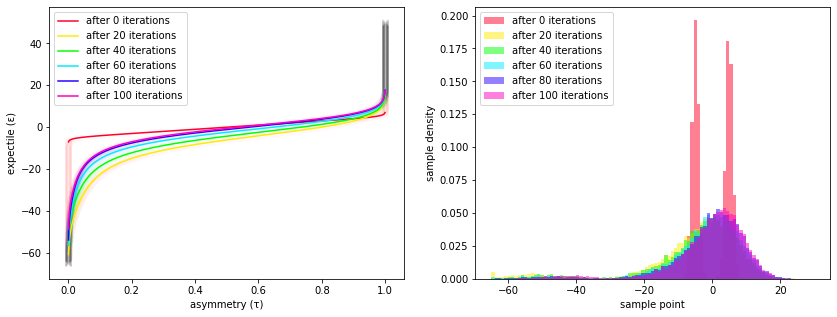

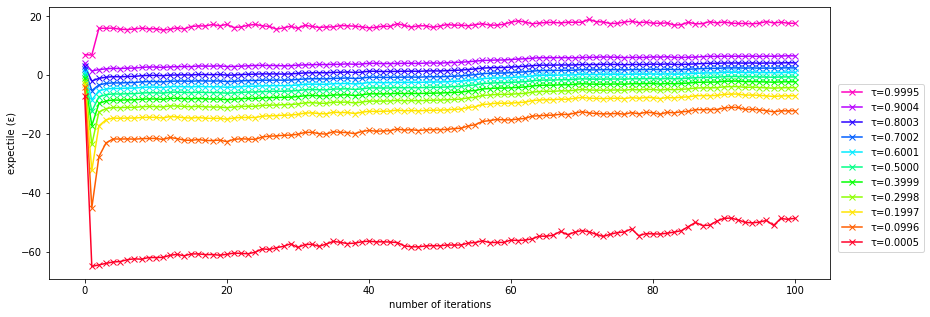

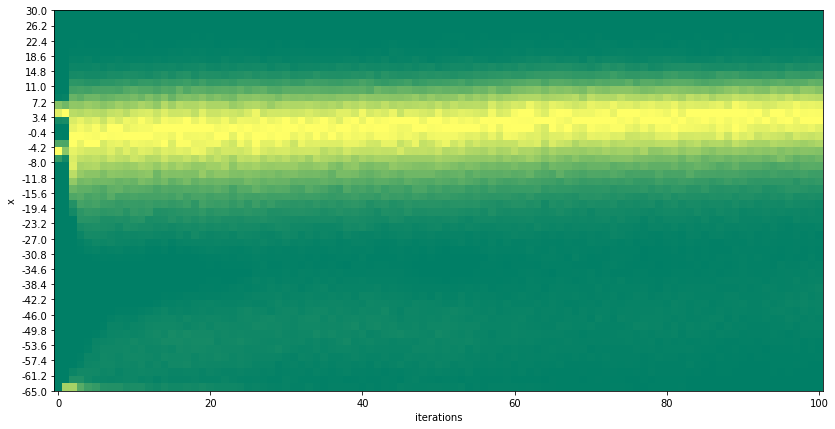

In [45]:
shift_experiment(tauspace(101), imputers.PolyLogitInterpImputer(), n_iterations=100)

In [47]:
shift_experiment(tauspace(101), imputers.PolyLogitInterpImputer(x=np.linspace(-50, 50, 2000)), n_iterations=1000)

**NOTE:** In the above there are some implicit range assumptions I snuck into the imputer based on knownlede of this distribution! Be careful!

### Skip imputation entirely and go straight to update?

imputation shift experiment with NonImputer()
n samples:     10000
n iterations:  20


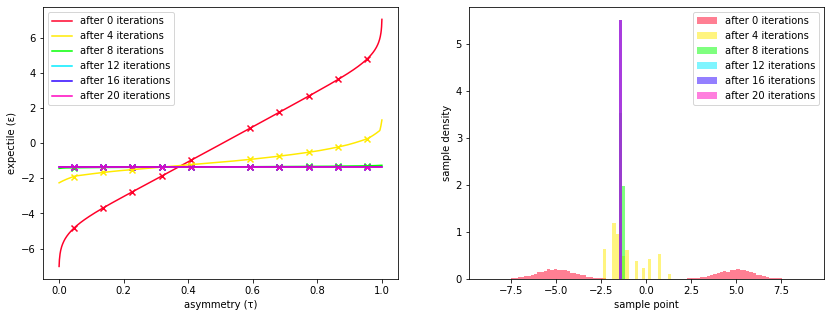

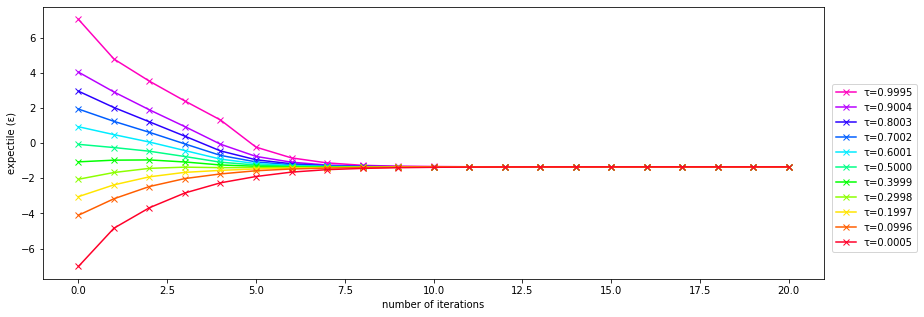

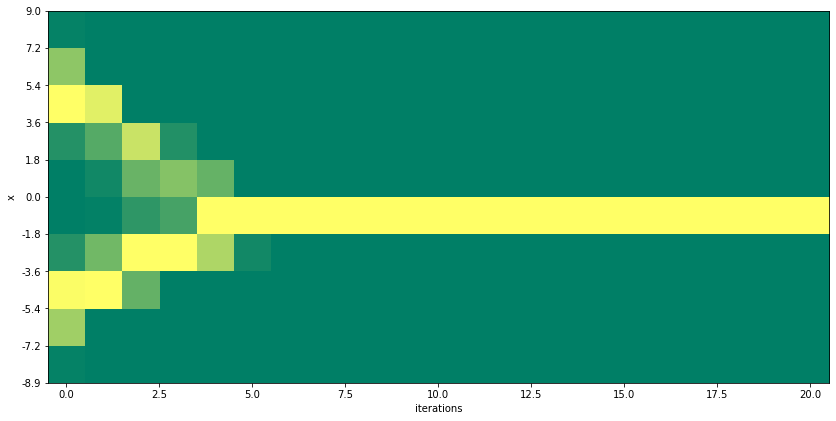

In [24]:
shift_experiment(tauspace(11), imputers.NonImputer(), n_iterations=20)

imputation shift experiment with NonImputer()
n samples:     10000
n iterations:  100


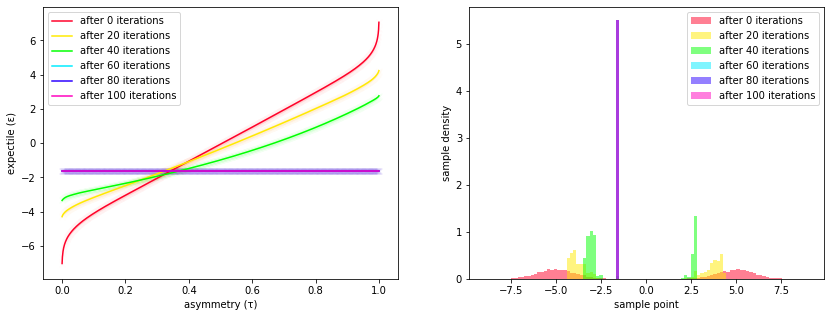

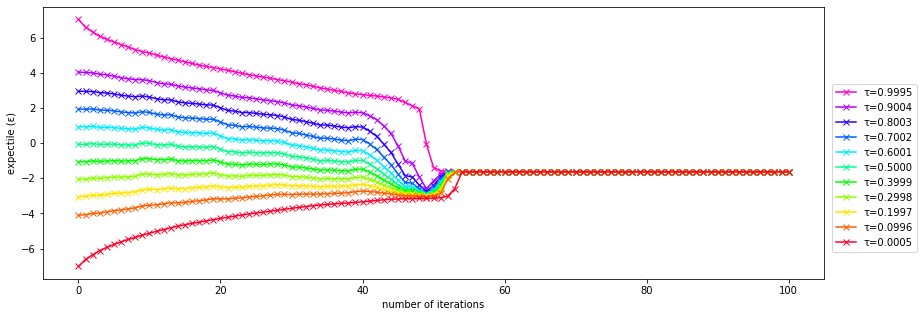

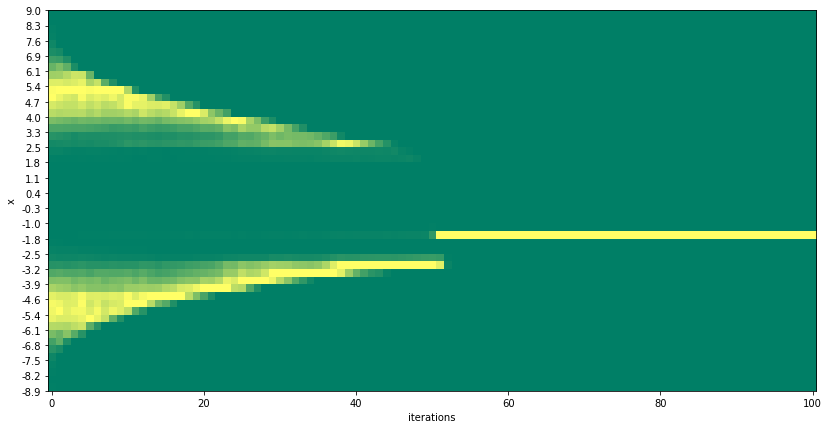

In [25]:
shift_experiment(tauspace(999), imputers.NonImputer(), n_iterations=100)

imputation shift experiment with NonImputer()
n samples:     10000
n iterations:  20


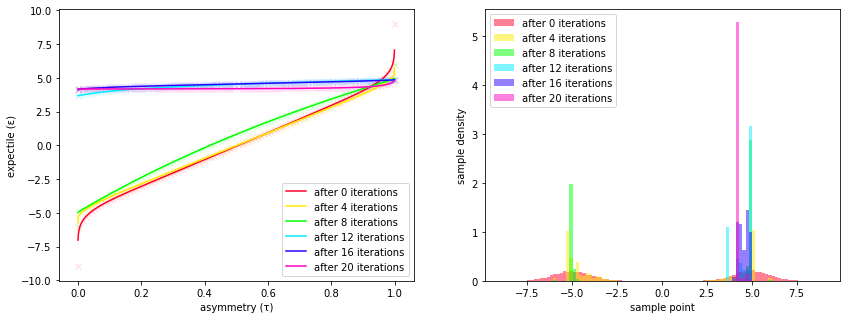

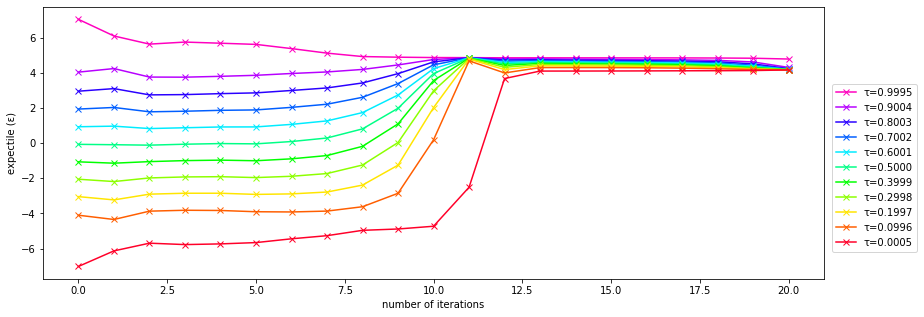

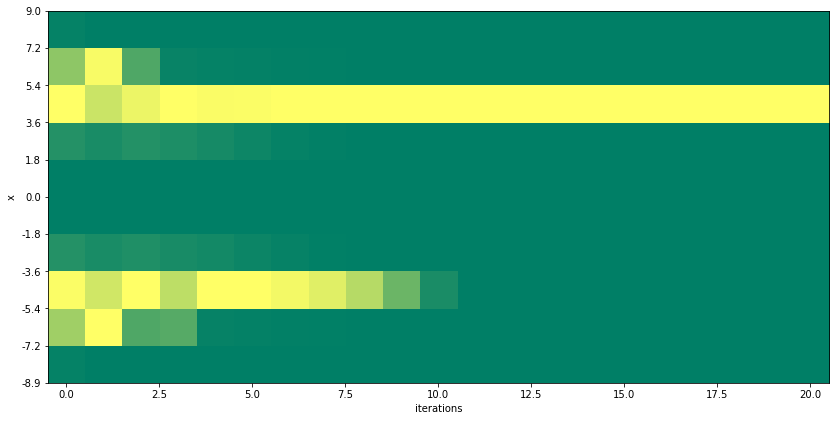

In [28]:
shift_experiment(full_tauspace(101), imputers.NonImputer(), n_iterations=20)

## Imputation *in*-stability---shift experiments *without* full tau ranges

We explore various expectile imputation strategies and their stability through repeated imputation.

In [49]:
def positive_shift_experiment(k, imputer, **kwargs):
    shift_experiment(tauspace(k)[k//2:],   imputer, i=0,    **kwargs)
def negative_shift_experiment(k, imputer, **kwargs):
    shift_experiment(tauspace(k)[:k//2+1], imputer, i=k//2, **kwargs)

imputation shift experiment with InterpolatingImputer()
n samples:     10000
n iterations:  100


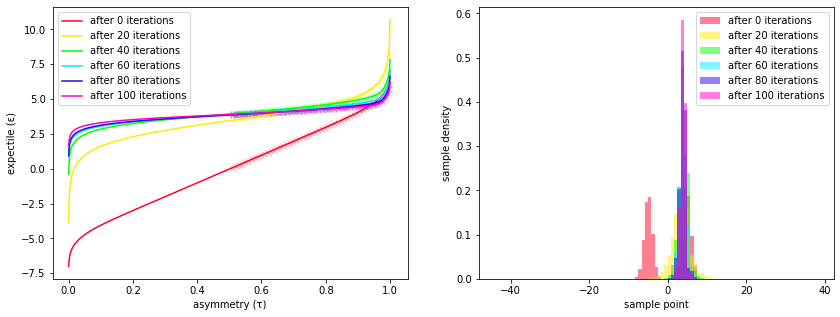

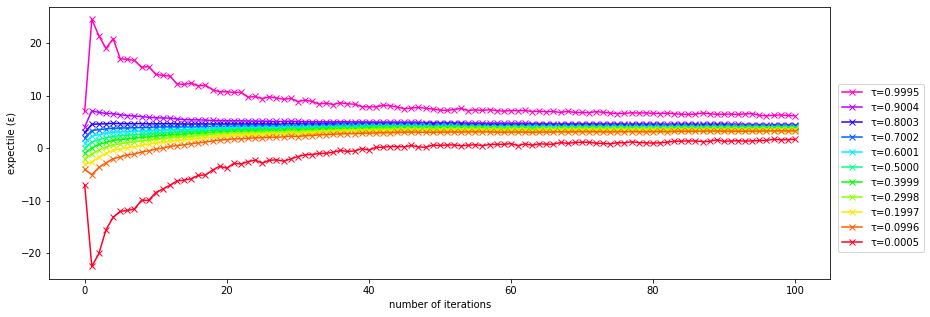

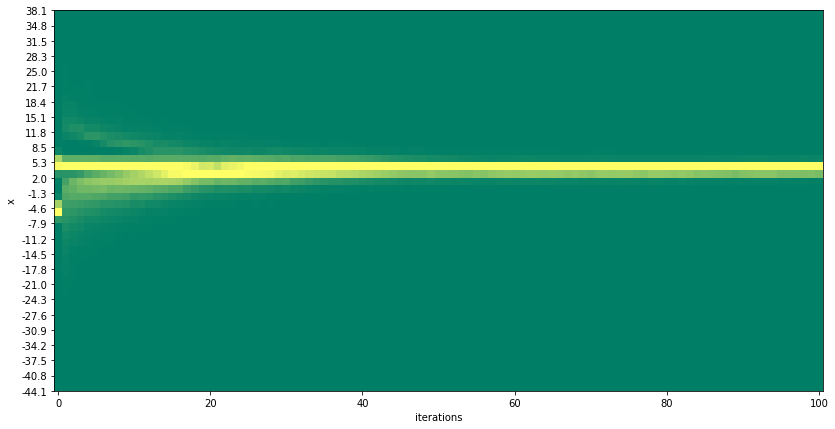

imputation shift experiment with InterpolatingImputer()
n samples:     10000
n iterations:  100


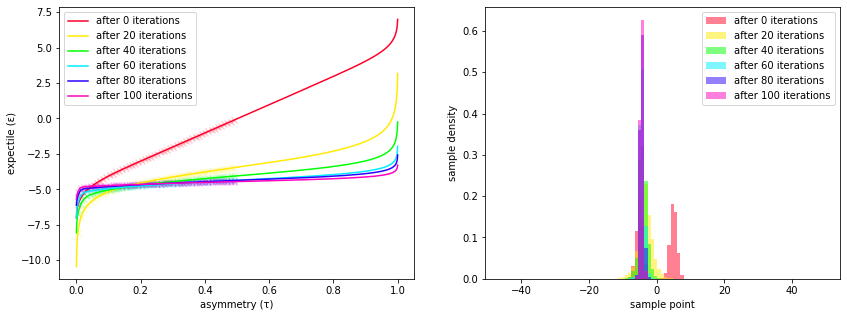

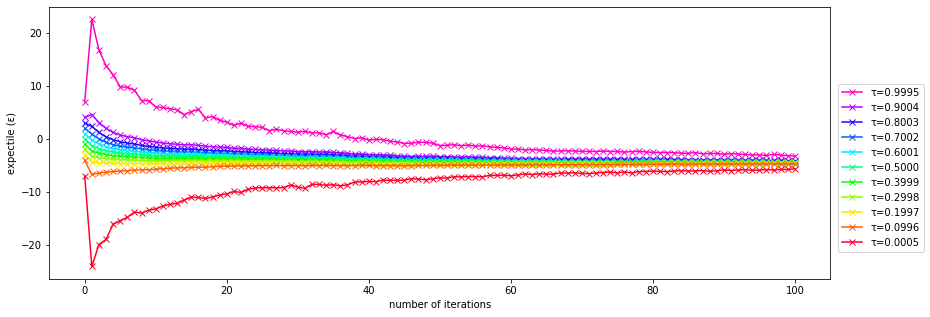

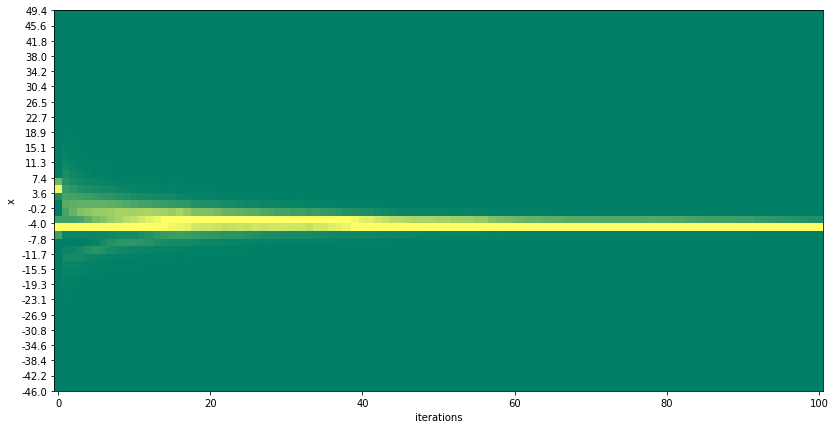

In [69]:
positive_shift_experiment(101, imputers.InterpolatingImputer(), n_iterations=100)
negative_shift_experiment(101, imputers.InterpolatingImputer(), n_iterations=100)

imputation shift experiment with DirectImputer(self.smooth_invert=True, self.exp_tails=True)
n samples:     10000
n iterations:  5


/Users/matt/Code/expectiles/imputers.py:19: RuntimeWarning: invalid value encountered in true_divide
  W /= W.sum(axis=-1, keepdims=True)


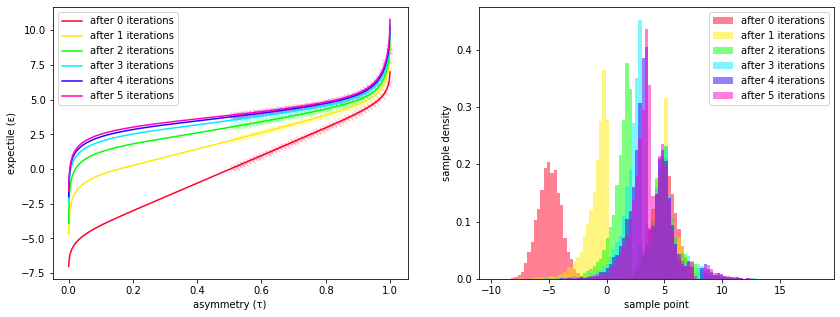

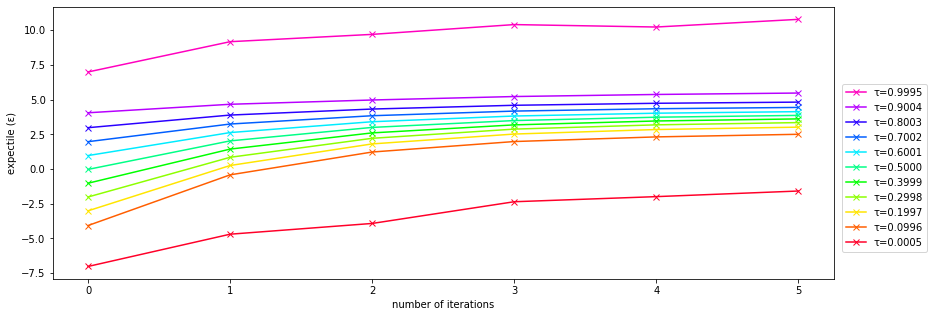

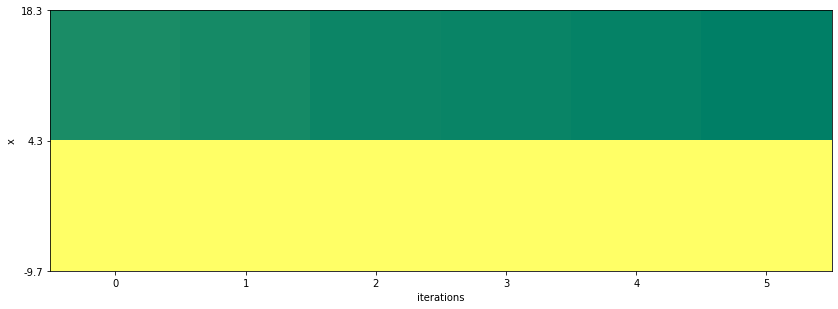

imputation shift experiment with DirectImputer(self.smooth_invert=True, self.exp_tails=True)
n samples:     10000
n iterations:  5


/Users/matt/Code/expectiles/imputers.py:19: RuntimeWarning: invalid value encountered in true_divide
  W /= W.sum(axis=-1, keepdims=True)


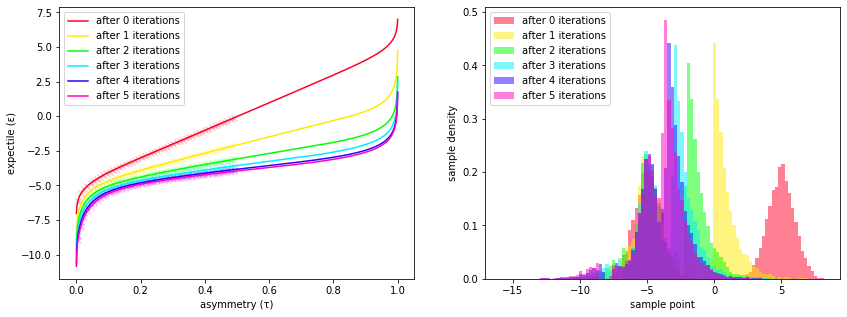

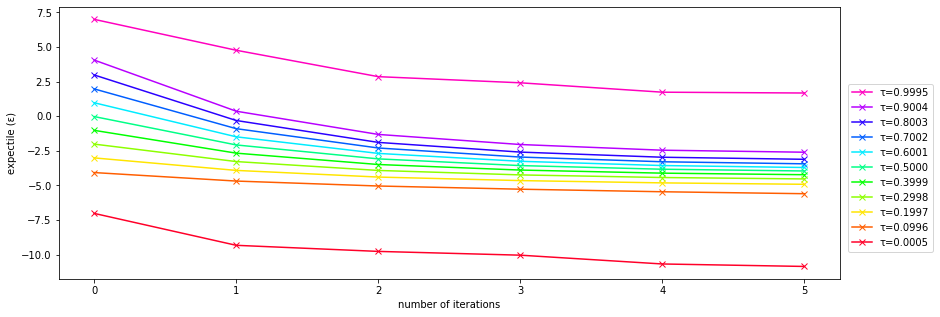

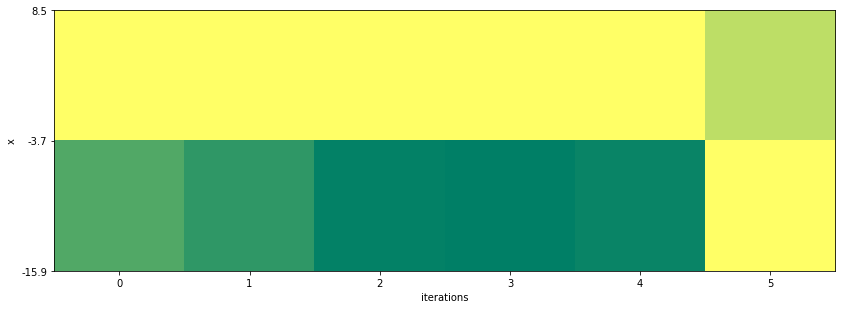

In [73]:
positive_shift_experiment(101, imputers.DirectImputer(smooth_invert=True, exp_tails=True), n_iterations=5)
negative_shift_experiment(101, imputers.DirectImputer(smooth_invert=True, exp_tails=True), n_iterations=5)

## Opt-based imputation

imputation shift experiment with OptBasedImputer(self.method='root', self.start='bestof1000')
n samples:     11
n iterations:  100


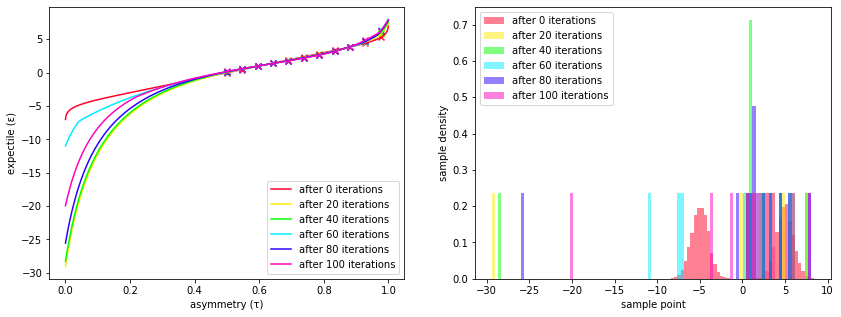

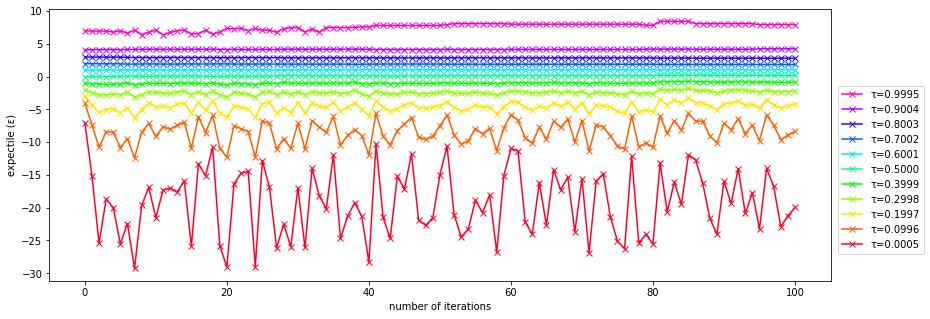

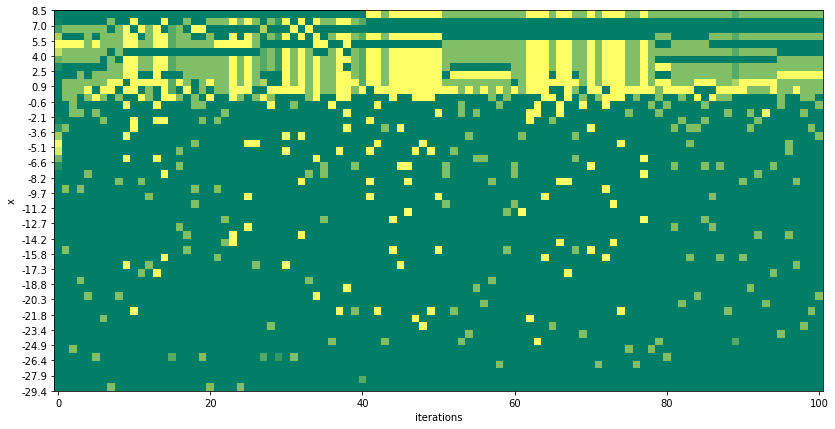

In [57]:
positive_shift_experiment(21, imputers.OptBasedImputer(), n_samples=11, n_iterations=100)

imputation shift experiment with OptBasedImputer(self.method='root', self.start='bestof1000')
n samples:     11
n iterations:  100


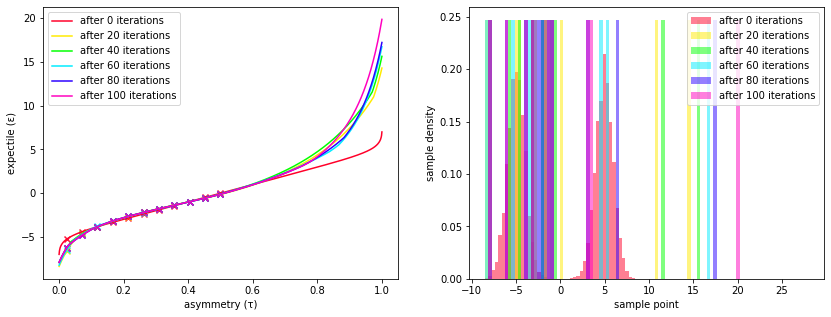

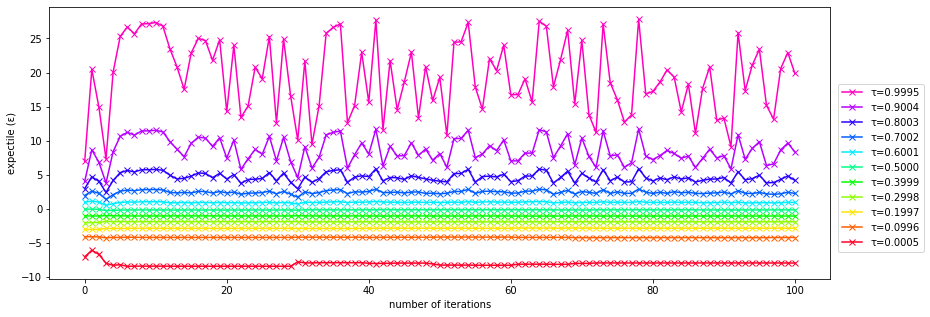

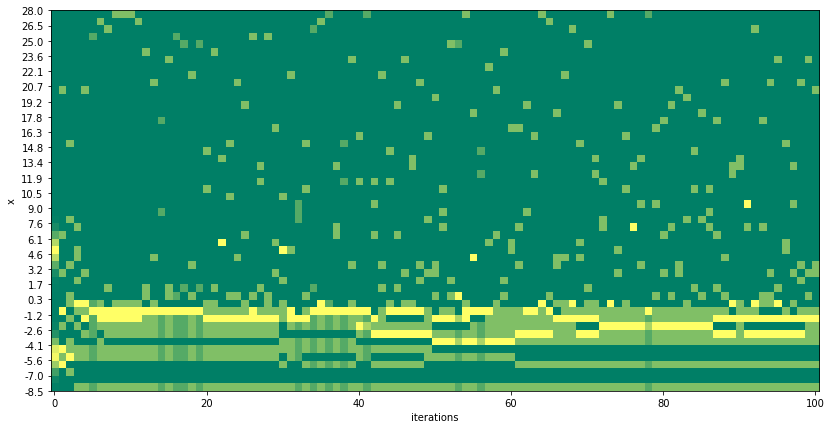

In [58]:
negative_shift_experiment(21, imputers.OptBasedImputer(), n_samples=11, n_iterations=100)